In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import matplotlib
font = {'size':16}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = 'white'
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import multivariate_normal

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [2]:
class net(nn.Module):
    def __init__(self, d, h, num_classes=2):
        super().__init__()
        self.linear1 = nn.Linear(d+1, h)
        self.linear2 = nn.Linear(h, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [3]:
def online_sample_from_task_sequence(t, N=10):
    if (t // N) % 2 == 0:
        mu = 1
    else:
        mu = -1
    Y = np.random.binomial(1, 0.5)
    X = np.random.normal((-1)**(Y+1)*mu, 0.5)
    return X, np.mod(t, 2*N)+1, Y

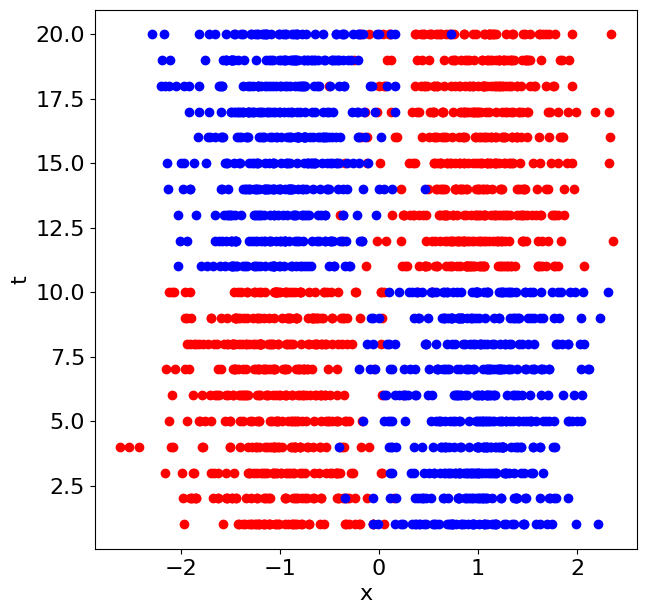

In [4]:
N = 10
T = 2000

Z = np.array([online_sample_from_task_sequence(t, N) for t in range(0, T+1)])
X = Z[:, :-1]
Y = Z[:, -1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X[Y==0][:, 0], X[Y==0][:, 1], c='red', label="class 0")
ax.scatter(X[Y==1][:, 0], X[Y==1][:, 1], c='blue', label="class 1")
ax.set_xlabel("x")
ax.set_ylabel("t")
plt.show()

In [5]:
torch_X = torch.Tensor(X)
torch_Y = torch.Tensor(Y)
dataset = TensorDataset(torch_X, torch_Y)
trainloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = net(d=1, h=10, num_classes=2)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
criterion = nn.CrossEntropyLoss()
num_epochs = 6000

for epoch in range(num_epochs):
    model.train()
    nb_batches = len(trainloader)
    losses = 0.0
    train_acc = 0.0
    for x, y in trainloader:
        x = x.to(device)
        y = y.long().to(device)

        out = model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        losses += loss.item()
        optimizer.step()
        train_acc += (out.argmax(1) == y).cpu().numpy().mean()
    scheduler.step()
    if epoch % 100 == 0:
        print("Training loss at epoch {} : {:4f}, Training Acc : {:4f}".format(epoch+1, losses/nb_batches, train_acc/nb_batches))

Training loss at epoch 1 : 0.705729, Training Acc : 0.518497
Training loss at epoch 101 : 0.488571, Training Acc : 0.815774
Training loss at epoch 201 : 0.196303, Training Acc : 0.924431
Training loss at epoch 301 : 0.155677, Training Acc : 0.941263
Training loss at epoch 401 : 0.126548, Training Acc : 0.960449
Training loss at epoch 501 : 0.114945, Training Acc : 0.963982
Training loss at epoch 601 : 0.105810, Training Acc : 0.966309
Training loss at epoch 701 : 0.101445, Training Acc : 0.966423
Training loss at epoch 801 : 0.091888, Training Acc : 0.972656
Training loss at epoch 901 : 0.093102, Training Acc : 0.969727
Training loss at epoch 1001 : 0.084277, Training Acc : 0.973633
Training loss at epoch 1101 : 0.083689, Training Acc : 0.975098
Training loss at epoch 1201 : 0.084273, Training Acc : 0.974724
Training loss at epoch 1301 : 0.088292, Training Acc : 0.972886
Training loss at epoch 1401 : 0.082845, Training Acc : 0.975586
Training loss at epoch 1501 : 0.088506, Training Acc

In [7]:
num_reps = 100
preds = []
gts = []
model.eval()
for rep in range(num_reps):
    Zt = np.array([online_sample_from_task_sequence(t, N) for t in range(T+1, 2*T+1)])
    Xt = torch.Tensor(Zt[:, :-1])
    Yt = Zt[:, -1]
    out = model(Xt)
    preds.append(out.detach().argmax(1).numpy())
    gts.append(Yt)
preds = np.array(preds)
gts = np.array(gts)
mean_error = np.mean(preds != gts, axis=0)
std_error = np.std(preds != gts, axis=0)
ci = std_error * 1.96/np.sqrt(num_reps)

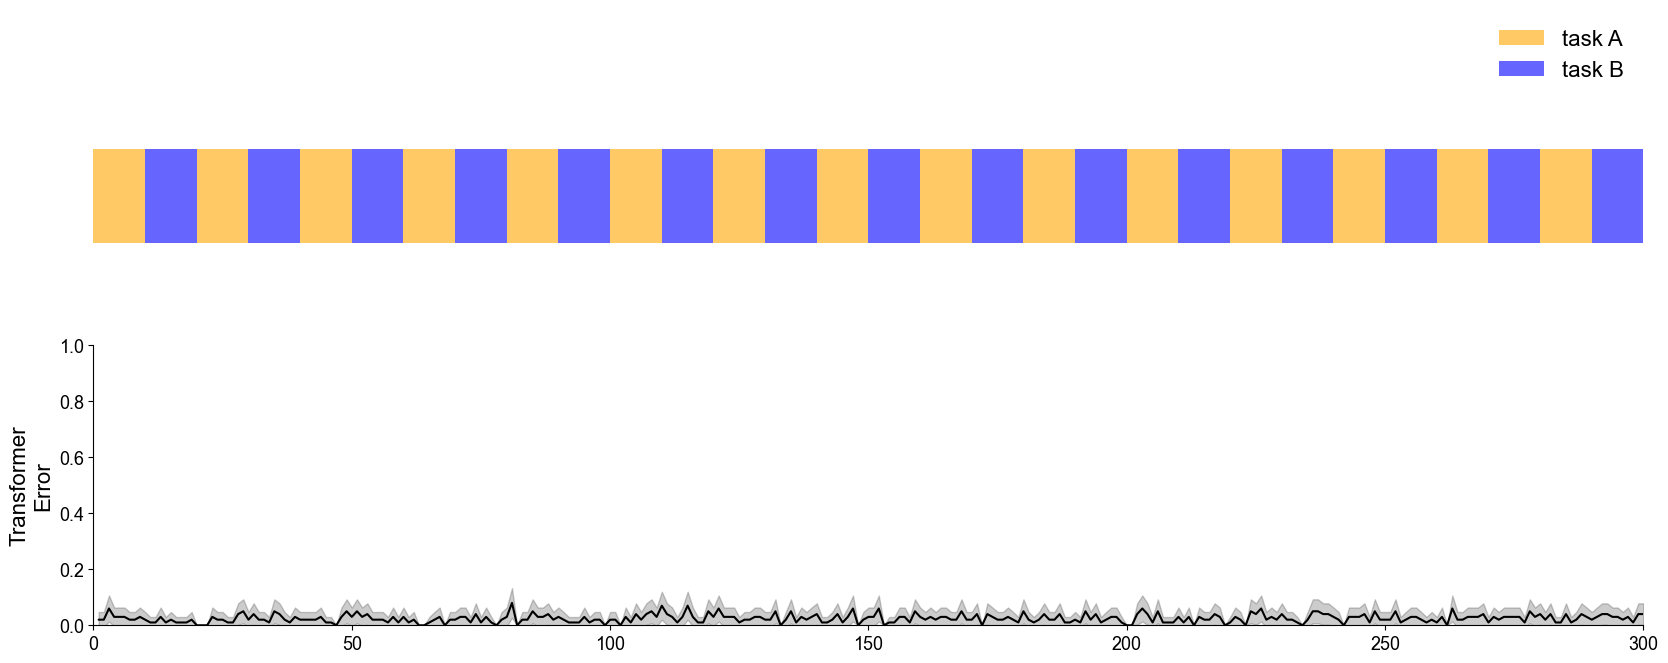

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
ax = axes[0]
end = 300+1
xlocs = np.arange(0, end, N)
for i, x in enumerate(xlocs):
    if i % 2 == 0:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='orange', alpha=0.6))
    else:
        ax.add_artist(Rectangle((x, 0), N, 2, fc='b', alpha=0.6))
ax.set_ylim([-1, 5])
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.legend(["task A", "task B"], loc=1, frameon=False, fontsize=16)
ax.axis('off')

sns.set_style("white")
sns.set_style("ticks")

ax = axes[1]
ax.plot(np.arange(1, end), mean_error[:end-1], c='k')
x = np.arange(1, end)
y = mean_error[:end-1]
c = ci[:end-1]
plt.fill_between(x, y-c, y+c, alpha=0.2, color='k')
ax.set_ylabel("Transformer" + "\n" + "Error", fontsize=16)
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=13)
ax.set_xlim([xlocs[0], xlocs[-1]])
ax.set_ylim([0, 1])
plt.show()
